### Predict customers future Credit spend based on historical spend data and demographics

In [1]:
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch.nn.functional as F

### Bigger the model with more nodes in hidden layers, and high numer of epochs the model performance improves
### Also tweaking the learning rate and using different activation functions would improve models performance.

In [2]:
df = pd.read_csv("Bank of Trust Dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32820 entries, 0 to 32819
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32820 non-null  int64  
 1   account_type           32820 non-null  object 
 2   gender                 32820 non-null  object 
 3   age                    32820 non-null  int64  
 4   region_code            32820 non-null  int64  
 5   cc_cons_apr            32820 non-null  float64
 6   dc_cons_apr            13768 non-null  float64
 7   cc_cons_may            32820 non-null  float64
 8   dc_cons_may            15481 non-null  float64
 9   cc_cons_jun            32820 non-null  float64
 10  dc_cons_jun            11523 non-null  float64
 11  cc_count_apr           30421 non-null  float64
 12  cc_count_may           31667 non-null  float64
 13  cc_count_jun           31230 non-null  float64
 14  dc_count_apr           13768 non-null  float64
 15  dc

In [4]:
#There are many columns with null values
# check for categorical_null_columns
cat_cols = [col for col in df.columns if df[col].dtype == "O" ]
cat_na = [col for col in df.columns if df[col].dtype == "O" and df[col].isnull().any()]

In [5]:
cat_na

['loan_enq']

In [6]:
num_cols = [col for col in df.columns if col not in cat_cols and col not in ["cc_cons"]]
num_na = [col for col in df.columns if col not in cat_cols and df[col].isnull().any() and col not in ["cc_cons"]]

In [7]:
num_na

['dc_cons_apr',
 'dc_cons_may',
 'dc_cons_jun',
 'cc_count_apr',
 'cc_count_may',
 'cc_count_jun',
 'dc_count_apr',
 'dc_count_may',
 'dc_count_jun',
 'card_lim',
 'personal_loan_active',
 'vehicle_loan_active',
 'personal_loan_closed',
 'vehicle_loan_closed',
 'investment_1',
 'investment_2',
 'investment_3',
 'investment_4',
 'debit_amount_apr',
 'credit_amount_apr',
 'debit_count_apr',
 'credit_count_apr',
 'max_credit_amount_apr',
 'debit_amount_may',
 'credit_amount_may',
 'credit_count_may',
 'debit_count_may',
 'max_credit_amount_may',
 'debit_amount_jun',
 'credit_amount_jun',
 'credit_count_jun',
 'debit_count_jun',
 'max_credit_amount_jun']

In [8]:
df[num_na] = df[num_na].fillna(0)
df[cat_na] = df[cat_na].fillna('N')

In [9]:
X = df.drop('cc_cons', axis = 1)
y = df['cc_cons']

In [10]:
from sklearn.compose import ColumnTransformer
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
## Setting Preprocessor Pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", scaler, num_cols),
    ("cat",ohe,cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# X_train.info()


In [11]:
## Apply data preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
## Convert Numpy to tensors
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype= torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

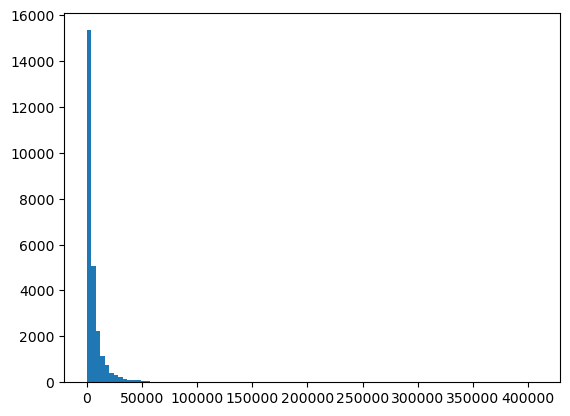

In [13]:
import matplotlib.pyplot as plt
plt.hist(y_train_tensor, bins = 100)
plt.show()

## Defining custom loss function

In [36]:
def rms_log_error(y_pred, y_true):
    
    # adding 1 to mitigate log(0) error
    y_pred = torch.clamp(y_pred, min= 0) + 1
    y_true = torch.clamp(y_true, min= 0) + 1
    
    # compute logarithms and then compute squared difference
    log_pred = torch.log(y_pred)
    log_true = torch.log(y_true)
    
    squared_log_error = (log_pred - log_true) ** 2
    
    # Compute mean and then sqrt
    mean_sqaure_log_error = torch.mean(squared_log_error)
    
    rms_log_err = torch.sqrt(mean_sqaure_log_error)
    
    return rms_log_err
        
    

In [37]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(X_train_tensor,y_train_tensor)

In [38]:

## define network
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #initializing layers
        self.fc1 = nn.Linear(X_train_tensor.shape[1],128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,1)
    
    #define activation functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [39]:
## Training with SGD and momentun 0.9

model = Net()
train_loss_list = []
test_loss_list = []
num_epochs = 30
optimizer = optim.SGD(model.parameters(),lr = 0.001, momentum=0.9)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
#Executing the training loop

for epoch in range(num_epochs):
    for X_batch,y_batch in train_loader:
        #forward pass
        pred = model(X_batch)
        loss = rms_log_error(pred, y_batch)
        
        #backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()    
    
    train_loss = rms_log_error(model(X_train_tensor), y_train_tensor)
    test_loss = rms_log_error(model(X_test_tensor), y_test_tensor)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    if (epoch+1) % 5 == 0: # printing after every 5 epochs
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        

Epoch 5: Train Loss: 2.4569, Test Loss: 2.4836
Epoch 10: Train Loss: 1.5236, Test Loss: 1.5428
Epoch 15: Train Loss: 1.3553, Test Loss: 1.3658
Epoch 20: Train Loss: 1.3257, Test Loss: 1.3310


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2757510144 bytes.

* Using Adam optimizer  
* Increasing the number of neurons in hidden layers 
* Changing the batch size from 

In [40]:

## define network
# Bigger network, Bigger Batch size and ADAM Optimizer
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #initializing layers
        self.fc1 = nn.Linear(X_train_tensor.shape[1],512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,32)
        self.fc4 = nn.Linear(32,1)
    
    #define activation functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [41]:
model = Net()
train_loss_list = []
test_loss_list = []
num_epochs = 30
optimizer = optim.Adam(model.parameters())

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
#Executing the training loop

for epoch in range(num_epochs):
    for X_batch,y_batch in train_loader:
        #forward pass
        pred = model(X_batch)
        loss = rms_log_error(pred, y_batch)
        
        #backward pass
        model.zero_grad()
        loss.backward()
        optimizer.step()    
    
    train_loss = rms_log_error(model(X_train_tensor), y_train_tensor)
    test_loss = rms_log_error(model(X_test_tensor), y_test_tensor)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    if (epoch+1) % 5 == 0: # printing after every 5 epochs
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 5: Train Loss: 1.3207, Test Loss: 1.3084
Epoch 10: Train Loss: 1.3156, Test Loss: 1.3035
Epoch 15: Train Loss: 1.3147, Test Loss: 1.3032


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2757510144 bytes.